#Imports

In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import datetime
import shutil
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from medmnist import NoduleMNIST3D
import scipy.ndimage as ndi
from scipy import ndimage
import random
from sklearn.utils.class_weight import compute_class_weight
from ipywidgets import interact, fixed

In [4]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard
# Clear any logs from previous runs
# shutil.rmtree('./logs/')

#Utils

In the 'utils' section, I gathered all the functions used throughout the notebook.

## Graphs

In [5]:
def plot_learning_curves(history):
  # Extract the training and validation loss
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  # Extract the training and validation accuracy
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  # Extract the training and validation AUC
  train_metric_key = list(history.history.keys())[2]
  val_metric_key = list(history.history.keys())[5]
  train_auc = history.history[train_metric_key]
  val_auc = history.history[val_metric_key]
  # Print Results
  print('Training Final: ACC = {}, AUC = {}'.format(train_accuracy[-1],train_auc[-1]))
  print('Validation Final: ACC = {}, AUC = {}'.format(val_accuracy[-1],val_auc[-1]))
  # Plot the learning curves
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(train_accuracy, label='Training Accuracy')
  plt.plot(val_accuracy, label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()
  plt.tight_layout()
  plt.show()

In [6]:
from sklearn.metrics import roc_curve, auc,confusion_matrix
def plot_roc_curve(model, val_dataset):
  y_true = []
  y_pred = []
  for x_batch, y_batch in val_dataset:
      y_true.extend(y_batch.numpy())
      y_pred.extend(model.predict(x_batch, verbose=0))
  #Calculate ROC curve
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  #Plot the curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

In [7]:
def plot_confusion_matrix(model,val_dataset):
  # Step 1: Make predictions on the test dataset
  y_true = []
  y_pred = []
  for X_batch, y_batch in val_dataset:
    y_true.extend(y_batch.numpy())
    y_pred.extend(np.round(model.predict(X_batch, verbose=0)))

  # Step 2: Compute confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  # Step 3: Plot confusion matrix
  plt.figure(figsize=(8, 6))
  plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  classes = ['Class 0', 'Class 1']  # Modify based on your class labels
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  thresh = conf_matrix.max() / 2.
  for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                  horizontalalignment="center",
                  color="white" if conf_matrix[i, j] > thresh else "black")
  plt.tight_layout()
  plt.show()

## Data

In [8]:
def dataset_details(dataset):
  imgs=[]
  labels=[]
  for img,label in dataset.take(1):
    imgs.append(img)
    labels.append(label)
  imgs=[tensor.numpy() for tensor in imgs][0]
  labels=[tensor.numpy() for tensor in labels][0]
  idx=random.randint(0, len(imgs))

  print('Number of batches = ',len(dataset))

  print('Sample of the dataset')
  show_slices(imgs[idx],label[idx])
  # interact(explore_images, image_data=fixed(imgs[idx]), label=fixed(label[idx]), slice_index=(0,27))

In [9]:
def tf_2_numpy(train_dataset):
  # Convert TensorFlow dataset batches to numpy arrays
  X_train_numpy = []
  y_train_numpy = []
  for batch in train_dataset:
      volumes, labels = batch
      # Convert volumes and labels tensors to numpy arrays
      volumes_numpy = volumes.numpy()
      labels_numpy = labels.numpy()

      # Flatten the batch dimensions and append to lists
      for volume, label in zip(volumes_numpy, labels_numpy):
          X_train_numpy.append(volume)
          y_train_numpy.append(label)

  # Convert lists to numpy arrays
  X_train_numpy = np.array(X_train_numpy)
  y_train_numpy = np.array(y_train_numpy)
  return X_train_numpy,y_train_numpy

In [10]:
def check_augmented_data(file_path):
  data=np.load(file_path)
  data=data['augmented_images']
  print('Samples in data: ',len(data))
  print('Shape = ',data.shape)
  # Show slices of a random sample
  random_idx=np.random.choice(len(data))
  img = data[random_idx]
  show_slices(img,random_idx)

In [11]:
def load_additional_data(file_path,imgs,labels,c):
  """
    This function loads additional data from a specified file path and integrates it into existing image and label arrays.
  """
  additional_volumes = np.load(file_path)['augmented_images']
  print('New images = ',additional_volumes.shape[0])
  #View sample
  idx=random.randint(0, len(additional_volumes))
  print('Random index = ',idx)
  if c=='m':
    additional_labels = np.ones((additional_volumes.shape[0],), dtype=np.int32)
    label='Malignant'
  elif c=='b':
    additional_labels = np.zeros((additional_volumes.shape[0],), dtype=np.int32)
    label='Benign'
  show_slices(additional_volumes[idx],label)
  imgs = np.concatenate([imgs, additional_volumes], axis=0)

  labels = np.concatenate([labels.flatten(), additional_labels], axis=0)
  return imgs,labels

## Display Images

In [12]:
def show_slices(image_data,label):
    num_slices = image_data.shape[2]
    num_cols = 7  # Display 7 columns for 28 slices
    num_rows = (num_slices // num_cols) + (1 if num_slices % num_cols != 0 else 0)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))  # Adjust the figure size
    fig.suptitle('All Slices of an Image , {}'.format(label), fontsize=16)

    for i in range(num_slices):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        ax.imshow(image_data[:, :, i], cmap='gray')
        ax.axis('off')
        ax.set_title(f"Slice {i}")

    # Hide any remaining empty subplots
    for i in range(num_slices, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()  # Adjust subplot parameters for better spacing
    plt.show()

In [13]:
def explore_images(image_data, label, slice_index=0):
    plt.figure(figsize=(5, 5))
    plt.imshow(image_data[:, :, slice_index], cmap='gray')
    plt.axis('off')
    plt.title(f"Slice {slice_index} , {label}")
    plt.show()

# Data Augmentation

To balance the dataset and generate additional samples, new data was created and saved in separate files. These augmented samples were later combined with the original dataset for model training. The augmentations applied were subtle to ensure minimal impact on the anatomical structures within the images.

##Augmentation functions

1. rotate_images(volume):

  * This function rotates a 3D volume of images by an angle chosen within a specified range.
  * It takes a 3D volume of images as input.
  * Randomly selects an angle within the range of -15 to +15 degrees for rotation.
  * Each slice of the input volume is rotated by this angle.
  * Returns the rotated 3D volume.

2. flip_images_within_slices(volume):

  * This function flips each image within each slice of the 3D volume.
  * It takes a 3D volume of images as input.
  * Iterates over each slice and flips each image within the slice.
  * Returns the volume with each image within each slice flipped.

3. add_gaussian_noise_3d(volume, sigma=0.001):

  * Adds Gaussian noise to each slice of a 3D volume of images.
  * Takes a 3D volume of images.
  * Generates Gaussian noise with very low intensity variation for each slice.
  * Adds the generated noise to the input volume.
  * Returns the noisy 3D volume.


In [ ]:
def rotate_images(volume):
    max_angle=15
    angle=np.random.uniform(-max_angle, max_angle)
    rotated_volume = np.zeros_like(volume)
    for i in range(volume.shape[0]):
        rotated_volume[i] = ndimage.rotate(volume[i], angle, reshape=False, mode='nearest')
    return rotated_volume

def flip_images(volume):
    flipped_volume = np.zeros_like(volume)
    for i in range(volume.shape[0]):
        for j in range(volume.shape[1]):
            flipped_volume[i, j] = np.flip(volume[i, j], axis=0)
    return flipped_volume


def add_gaussian_noise_3d(volume, sigma=0.001):
    noise = np.random.normal(loc=0, scale=sigma, size=volume.shape)
    noisy_volume = volume + noise
    return noisy_volume

def generate_augmented_images(volumes):
    # augmented_images_rotated = []
    augmented_images_flipped = []
    for volume in volumes:
      augmented_volume = volume.copy()

      # augmented_volume_rotate = rotate_images(augmented_volume)
      augmented_volume_flip = flip_images(augmented_volume)

      # augmented_images_rotated.append(augmented_volume_rotate)
      augmented_images_flipped.append(augmented_volume_flip)

    # np.savez('rotated_augmented_images.npz', augmented_images=augmented_images_rotated)
    np.savez('flipped_augmented_images.npz', augmented_images=augmented_images_flipped)

# def generate_augmented_images(volumes,c):
#     augmented_images_varied = []
#     for volume in volumes:
#       augmented_volume = volume.copy()
#       augmented_volume = add_gaussian_noise_3d(augmented_volume)
#       augmented_images_varied.append(augmented_volume)

#     np.savez('noisy_images_{}.npz'.format(c), augmented_images=augmented_images_varied)

In [ ]:
train_data=NoduleMNIST3D(split="train", download=True)

100%|██████████| 29299364/29299364 [00:33<00:00, 870579.07it/s] 


## Generating

In [ ]:
train_imgs=train_data.imgs
train_labels=train_data.labels

In [ ]:
indices = np.where(train_labels == 0)[0]
benign_images = train_imgs[indices]

In [ ]:
indices = np.where(train_labels == 1)[0]
malignant_images = train_imgs[indices]

In [ ]:
generate_augmented_images(malignant_images)

In [ ]:
# generate_augmented_images(malignant_images,c='m')

In [ ]:
# generate_augmented_images(benign_images[:280],c='b')

In [ ]:
# import shutil
# import os
# file_path = "/content/flipped_augmented_images.npz"
# destination_folder = "/content/drive/MyDrive/Data/nodule"
# if not os.path.exists(destination_folder):
#     os.makedirs(destination_folder)
# shutil.move(file_path, destination_folder)
# print("File moved successfully to", destination_folder)

File moved successfully to /content/drive/MyDrive/Data/nodule


## Checking generated images

Check the rotated images

In [ ]:
file_path='/content/drive/MyDrive/Data/nodule/rotated_augmented_images.npz'

Samples in data:  295
Shape =  (295, 28, 28, 28)


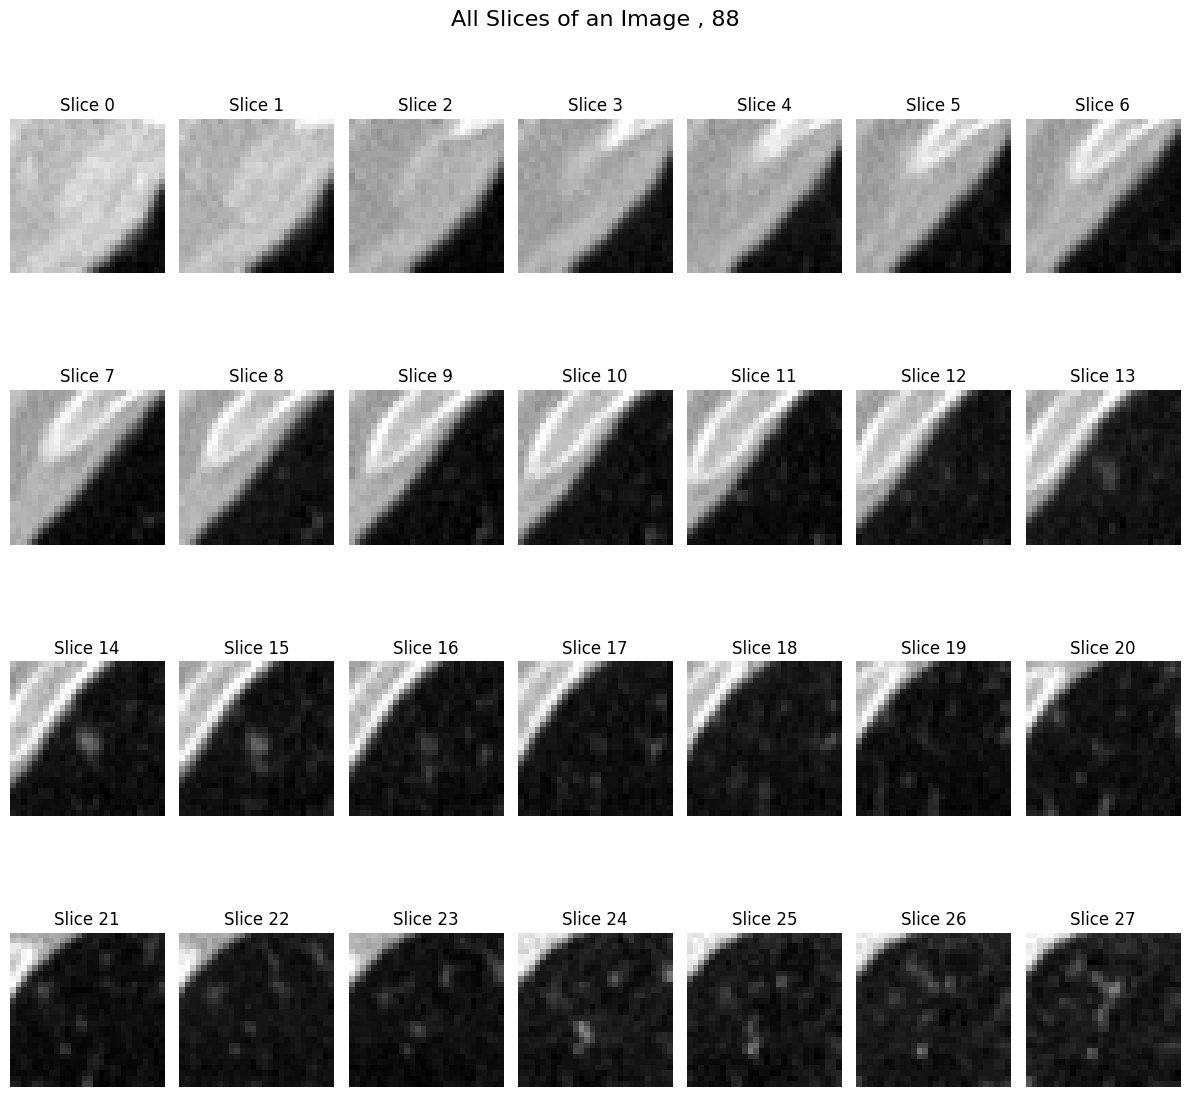

In [ ]:
check_augmented_data(file_path)

Check the flipped images

In [ ]:
file_path='/content/drive/MyDrive/Data/nodule/flipped_augmented_images.npz'

Samples in data:  295
Shape =  (295, 28, 28, 28)


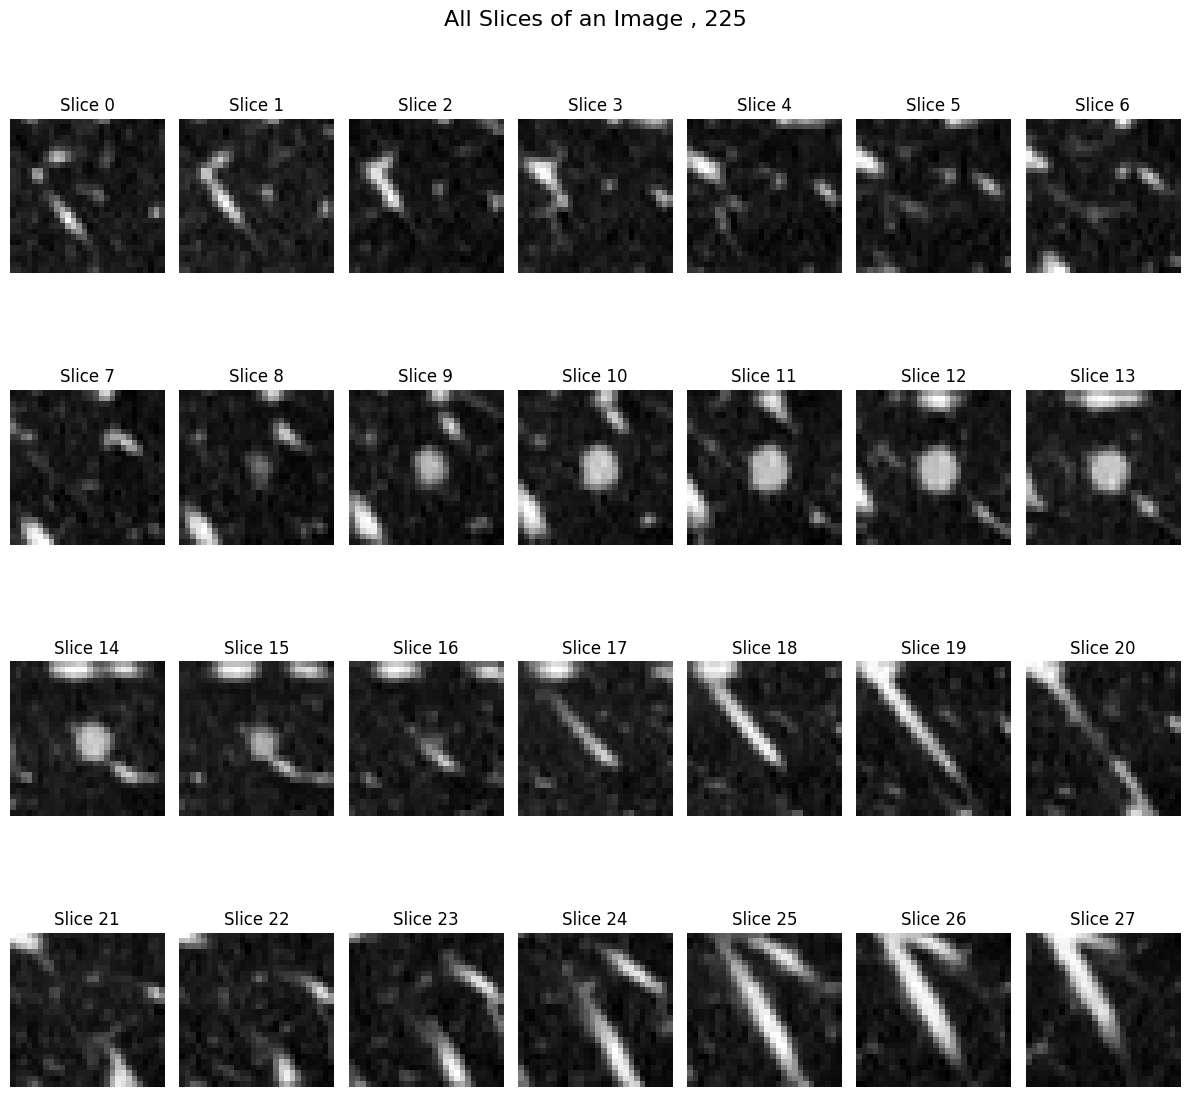

In [ ]:
check_augmented_data(file_path)

Check the noisy images

In [ ]:
#malignant
file_path='/content/drive/MyDrive/Data/nodule/noisy_images_m.npz'

Samples in data:  295
Shape =  (295, 28, 28, 28)


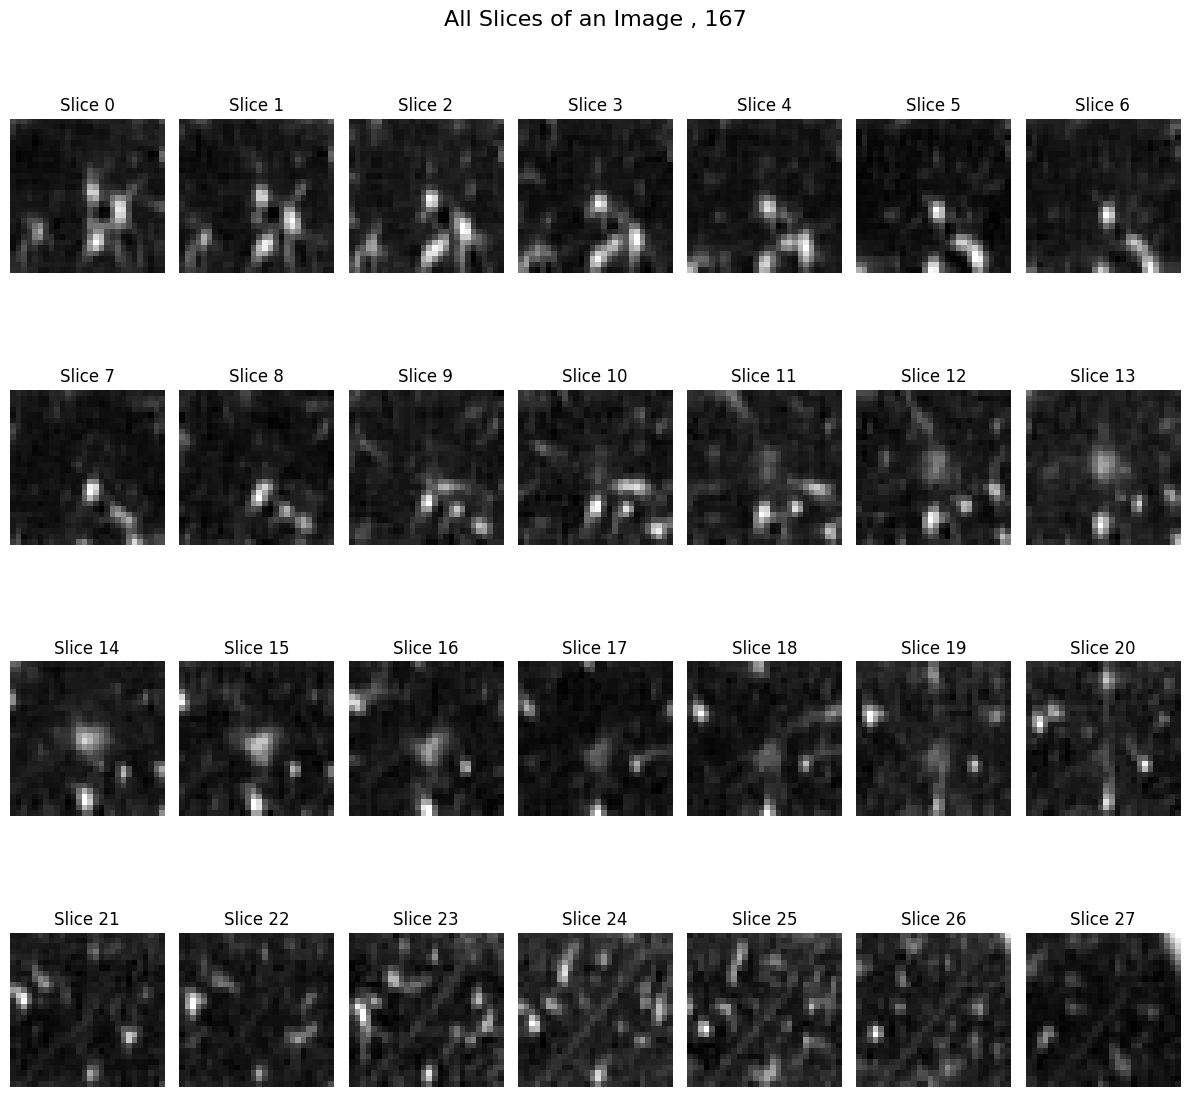

In [ ]:
check_augmented_data(file_path)

In [ ]:
#benign
file_path='/content/drive/MyDrive/Data/nodule/noisy_images_b.npz'

Samples in data:  280
Shape =  (280, 28, 28, 28)


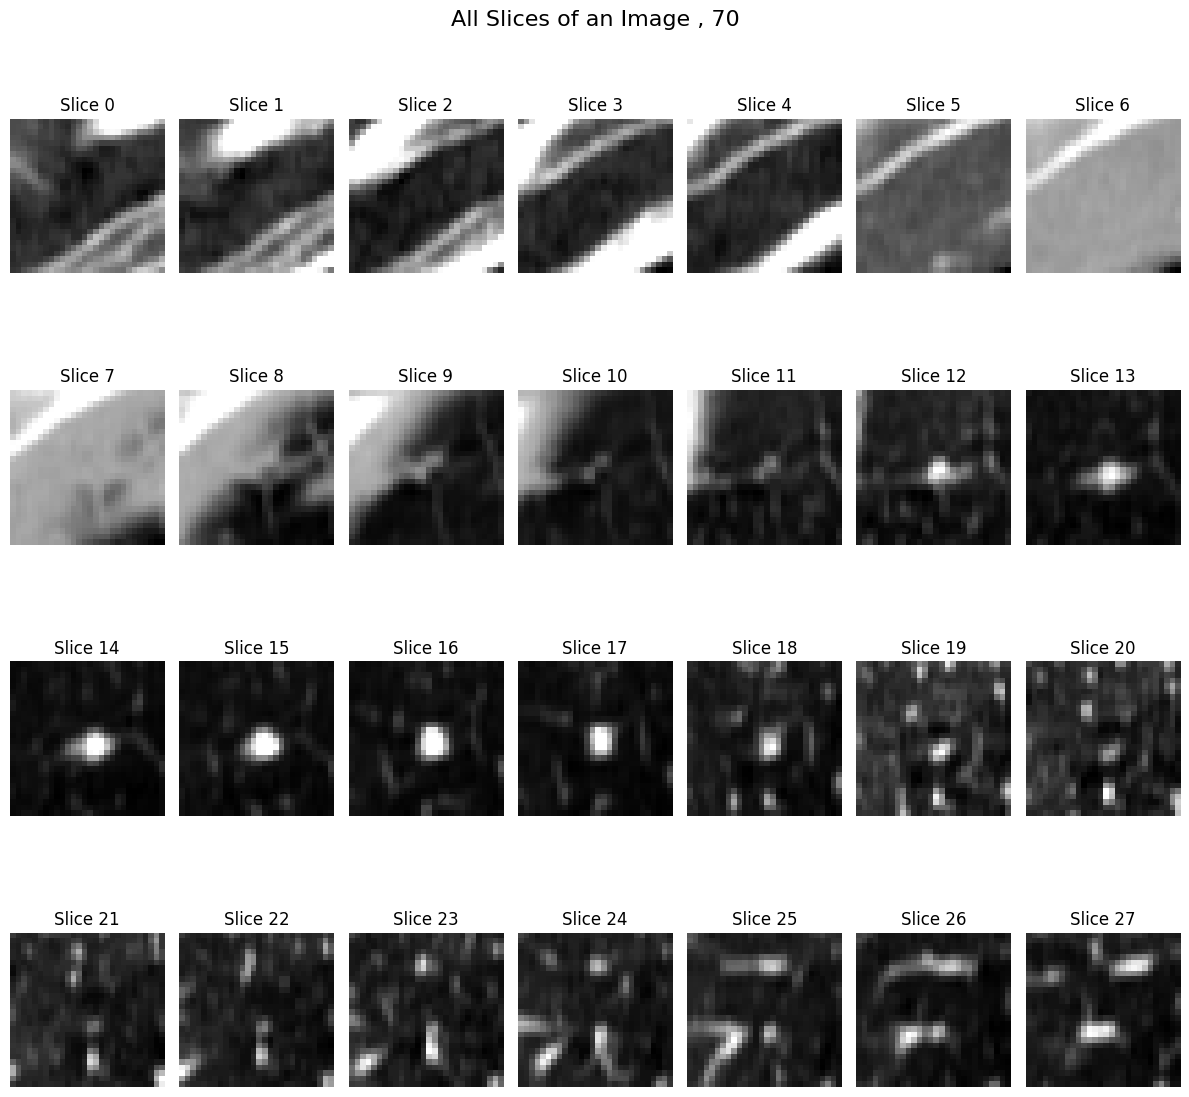

In [ ]:
check_augmented_data(file_path)

# Data

##Loading data

In [14]:
def load_nodulemnist():
  train_data = NoduleMNIST3D(split="train", download=True)
  val_data = NoduleMNIST3D(split="val", download=True)

  train_imgs=train_data.imgs
  train_labels=train_data.labels

  val_imgs=val_data.imgs
  val_labels=val_data.labels

  return train_imgs,train_labels,val_imgs,val_labels

## Exploring data

In [15]:
train_imgs,train_labels,val_imgs,val_labels=load_nodulemnist()

100%|██████████| 29299364/29299364 [00:02<00:00, 13278289.83it/s]


Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz


In [16]:
print('Images shape= ', train_imgs[0].shape)
print('Train data=', len(train_imgs),' samples')
print('Validation data=', len(val_imgs),' samples')

Images shape=  (28, 28, 28)
Train data= 1158  samples
Validation data= 165  samples


In [17]:
np.bincount(train_labels.flatten())

array([863, 295])

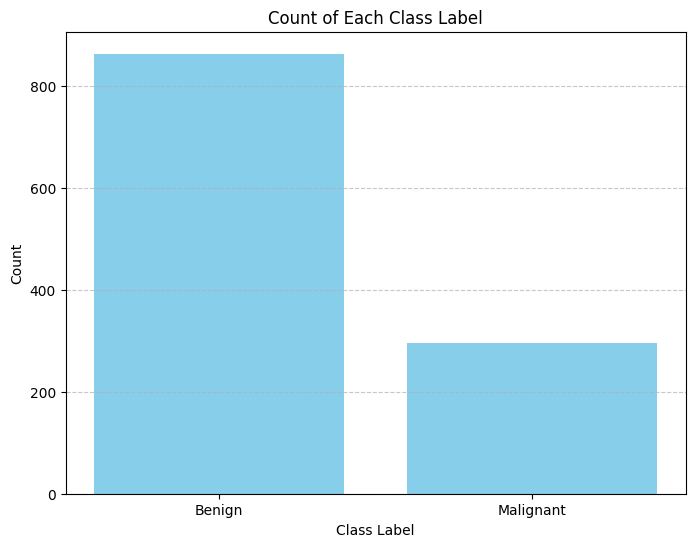

In [18]:
unique_labels, label_counts = np.unique(train_labels, return_counts=True)
class_labels = {0: 'Benign', 1: 'Malignant'}
# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, label_counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Count of Each Class Label')
plt.xticks(list(class_labels.keys()), [class_labels[label] for label in unique_labels])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [19]:
random_benign_idx=np.random.choice(np.where(train_labels == 0)[0])
random_malignant_idx=np.random.choice(np.where(train_labels == 1)[0])

Display a benign image

In [20]:
benign_image = train_imgs[random_benign_idx]

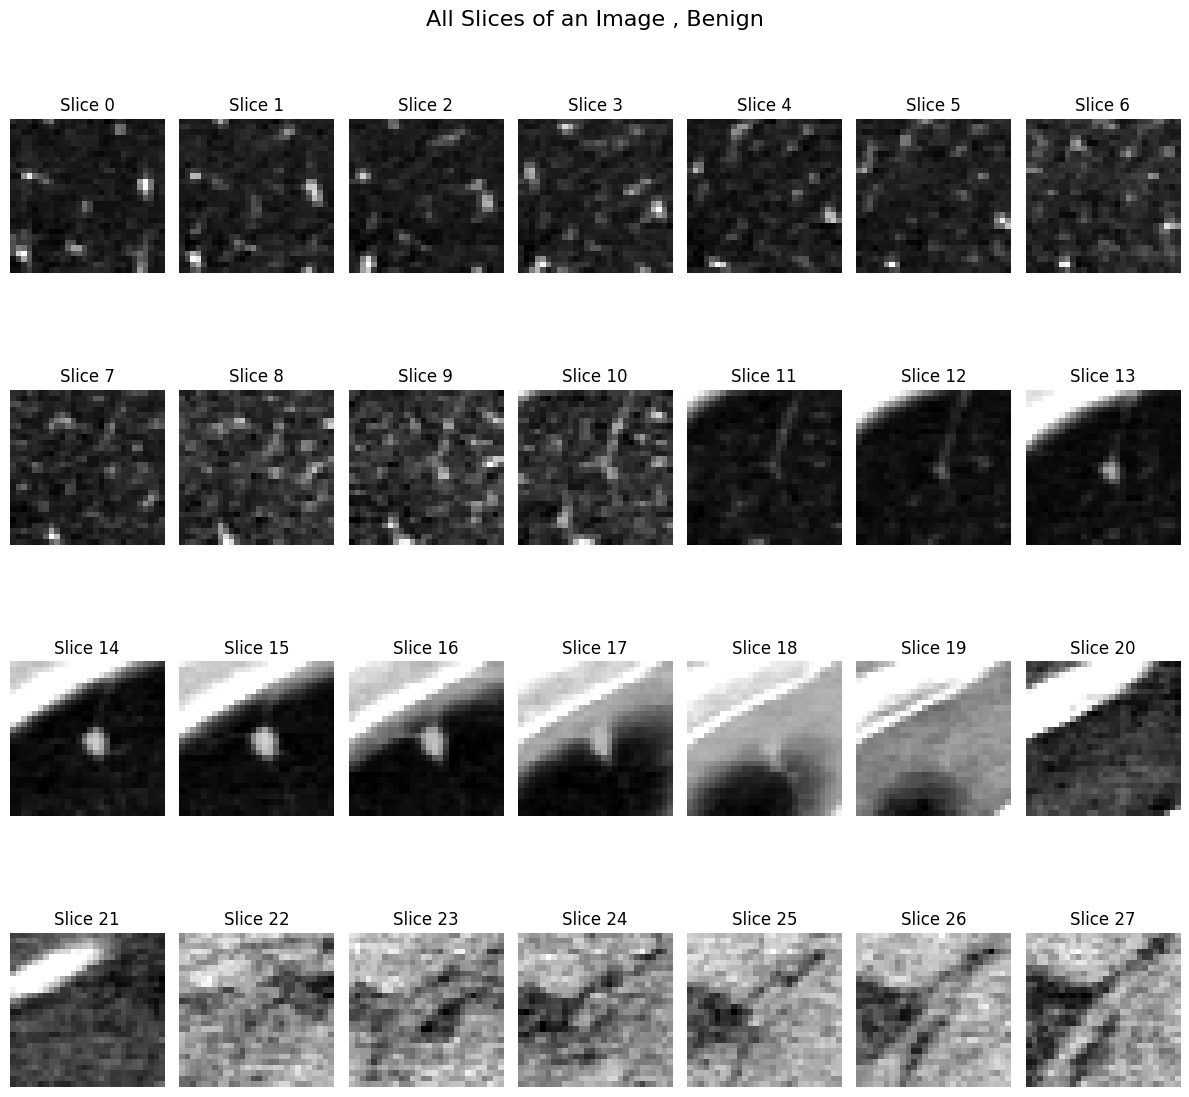

In [21]:
show_slices(benign_image,'Benign')

In [22]:
interact(explore_images, image_data=fixed(benign_image), label=fixed('Benign'), slice_index=(0,27))

interactive(children=(IntSlider(value=0, description='slice_index', max=27), Output()), _dom_classes=('widget-…

<function __main__.explore_images(image_data, label, slice_index=0)>

Display a malignant image

In [23]:
malignant_image = train_imgs[random_malignant_idx]

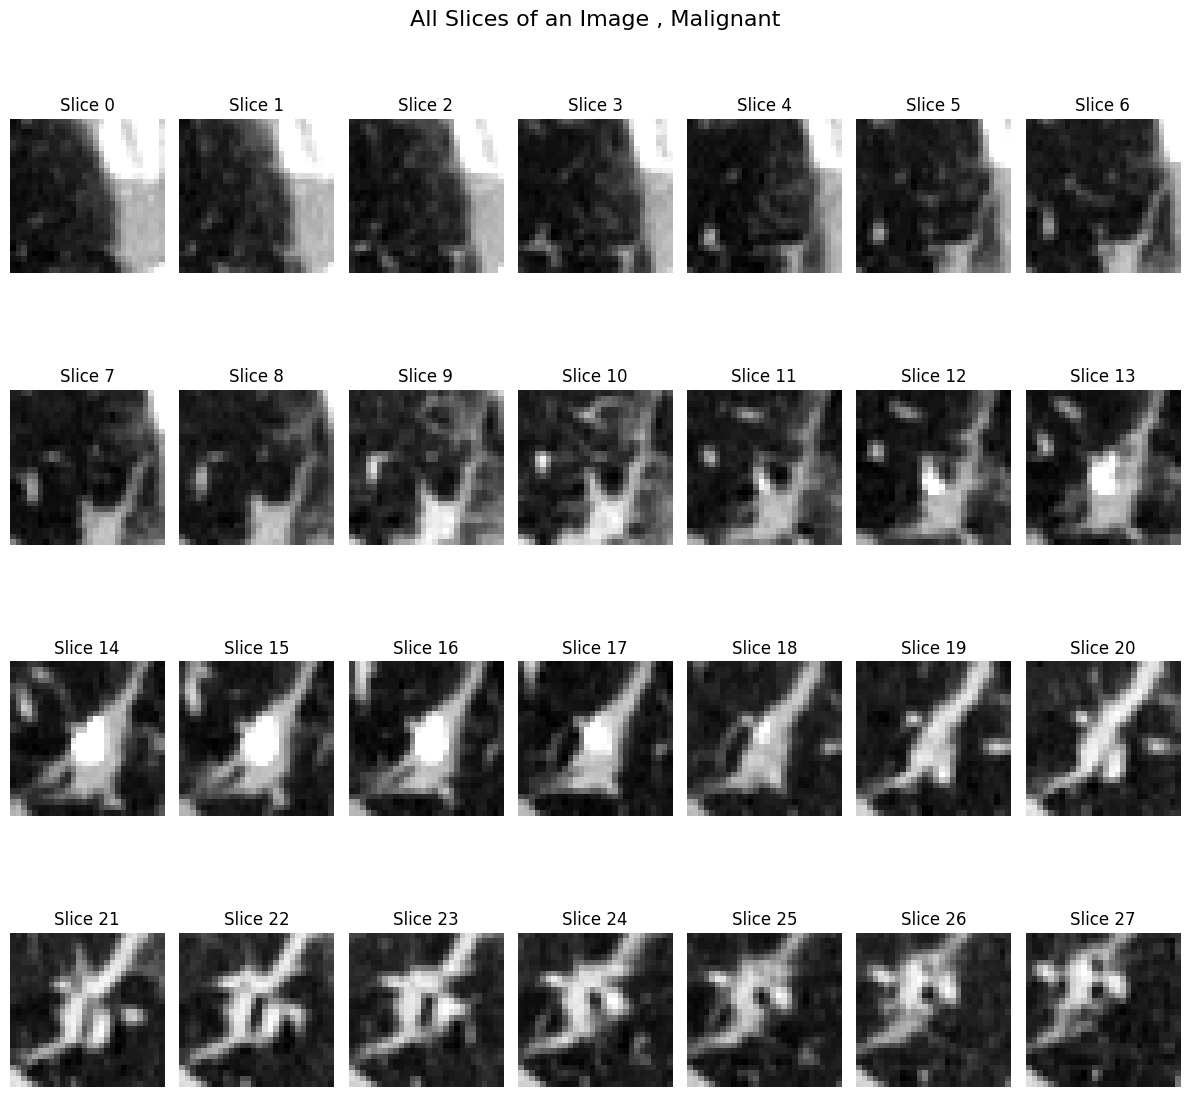

In [24]:
show_slices(malignant_image,'Malignant')

In [25]:
interact(explore_images, image_data=fixed(malignant_image), label=fixed('Malignant'), slice_index=(0,27))

interactive(children=(IntSlider(value=0, description='slice_index', max=27), Output()), _dom_classes=('widget-…

<function __main__.explore_images(image_data, label, slice_index=0)>

##Additional Data

New images =  295
Random index =  29


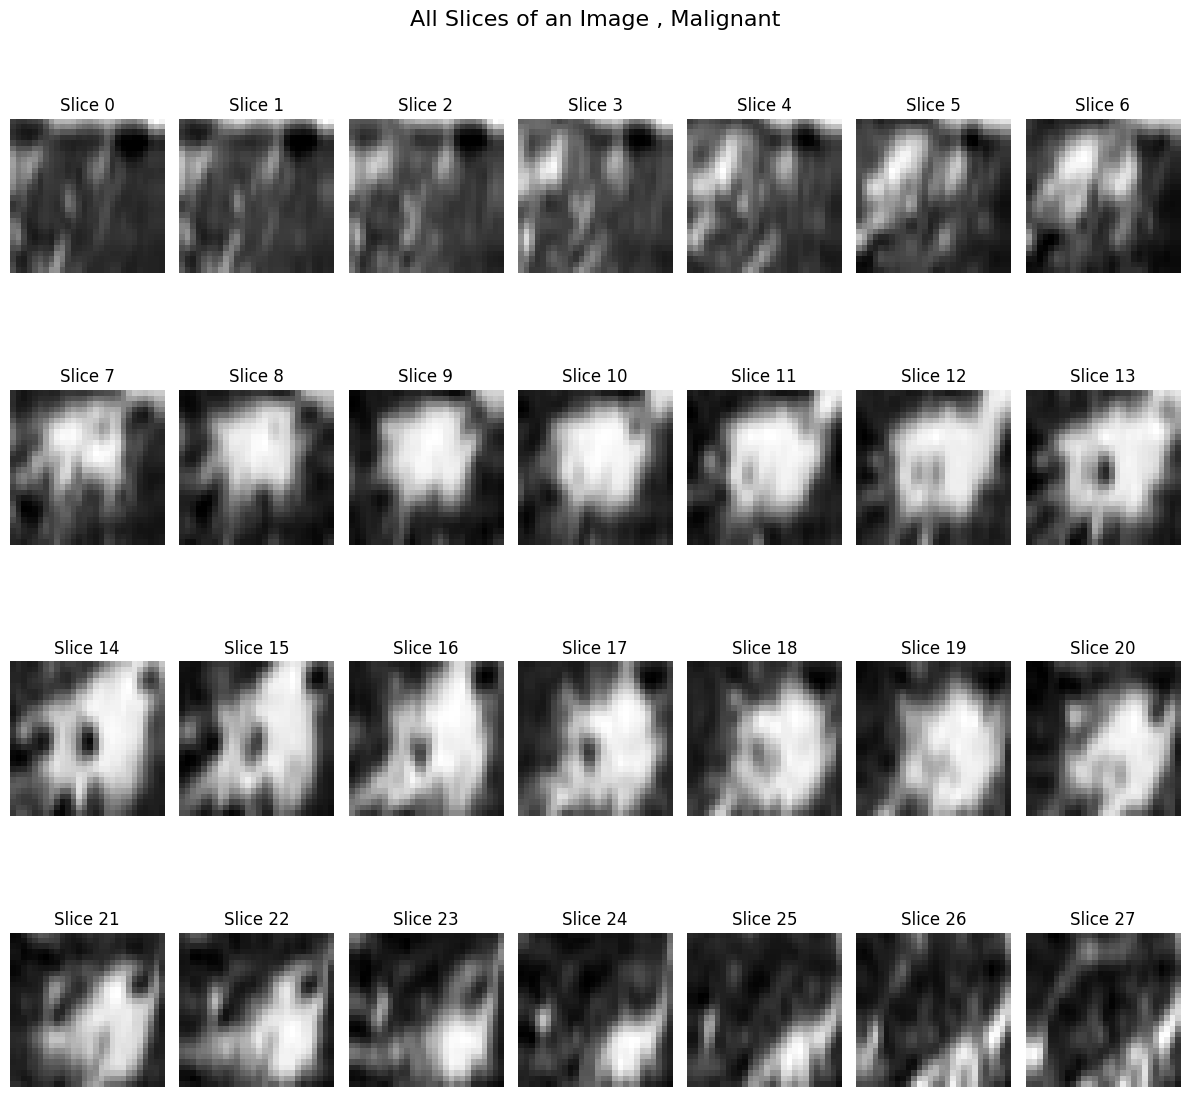

In [26]:
train_imgs,train_labels=load_additional_data('/content/drive/MyDrive/Data/nodule/rotated_augmented_images.npz',train_imgs,train_labels,c='m')

New images =  295
Random index =  139


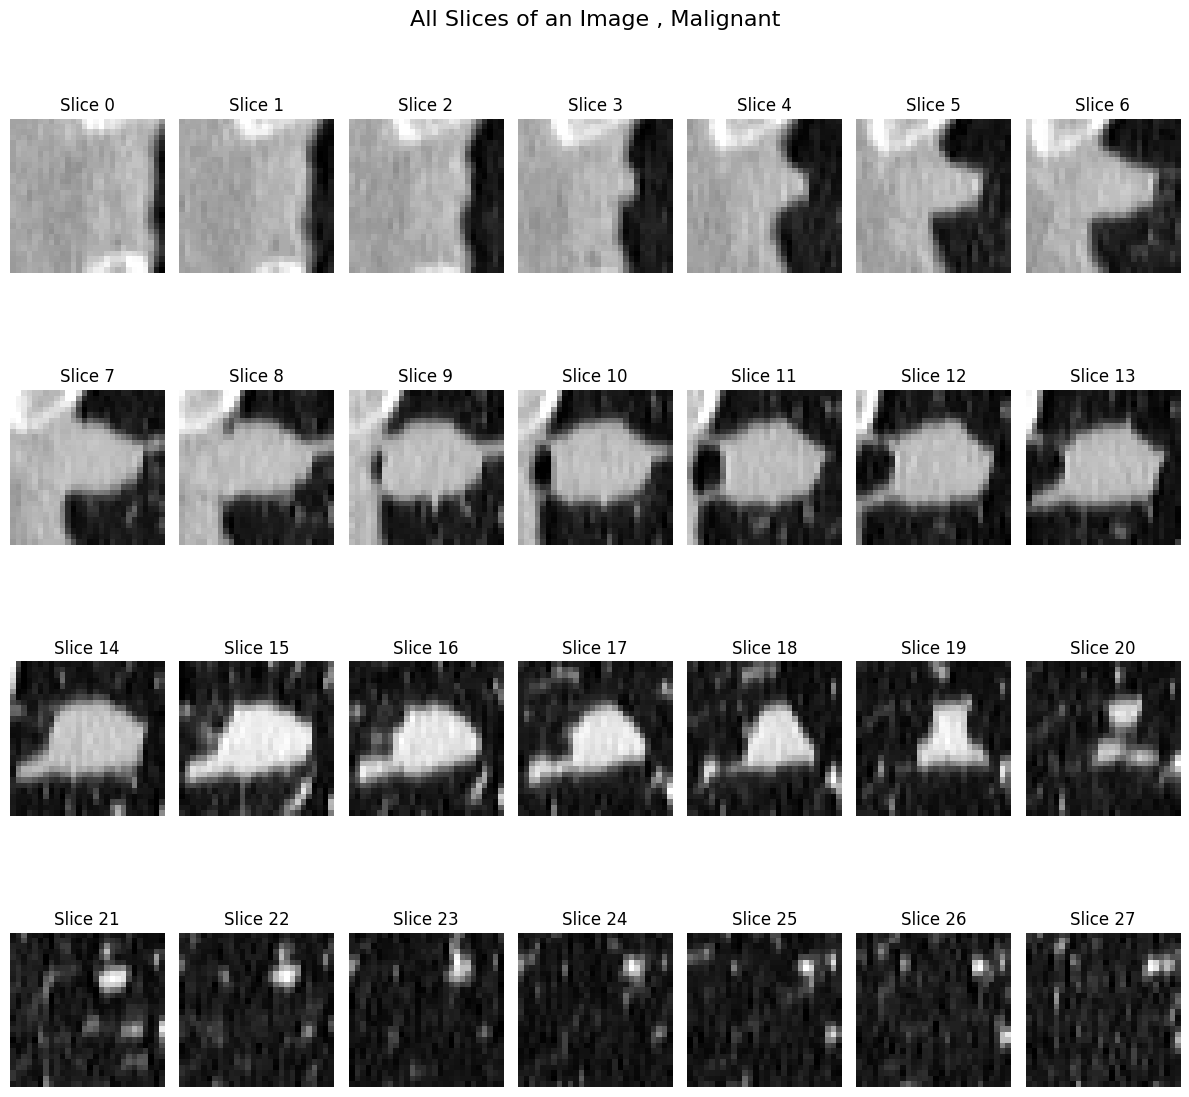

In [27]:
train_imgs,train_labels=load_additional_data('/content/drive/MyDrive/Data/nodule/flipped_augmented_images.npz',train_imgs,train_labels,c='m')

New images =  295
Random index =  14


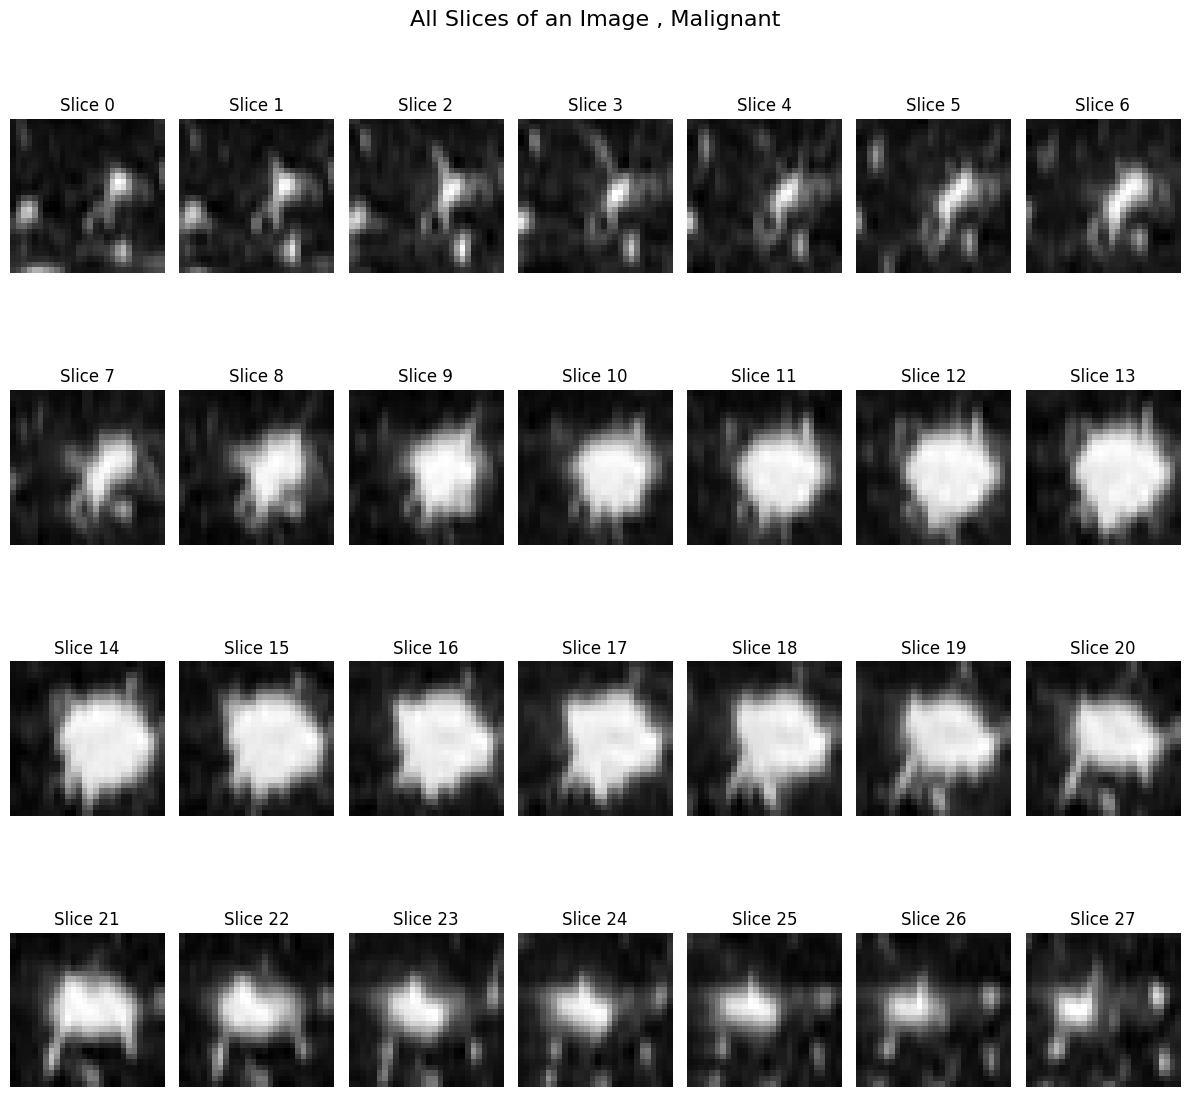

In [28]:
train_imgs,train_labels=load_additional_data('/content/drive/MyDrive/Data/nodule/noisy_images_m.npz',train_imgs,train_labels,c='m')

New images =  280
Random index =  101


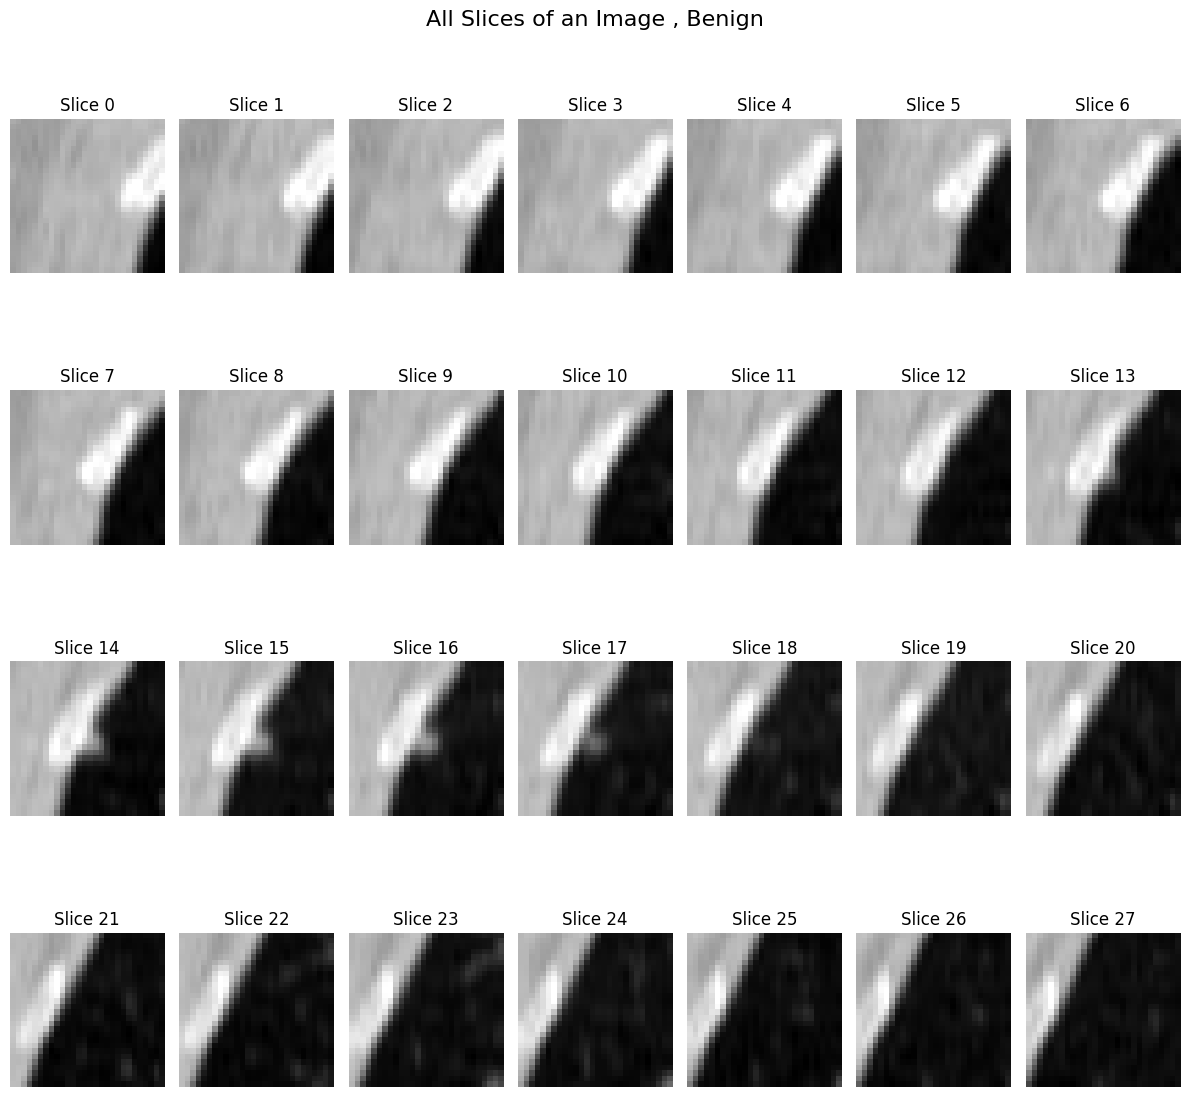

In [29]:
train_imgs,train_labels=load_additional_data('/content/drive/MyDrive/Data/nodule/noisy_images_b.npz',train_imgs,train_labels,c='b')

In [30]:
print('Train data = ', len(train_imgs),' samples')
print('Train data shape = ',train_imgs.shape)

Train data =  2323  samples
Train data shape =  (2323, 28, 28, 28)


In [31]:
np.bincount(train_labels.flatten())

array([1143, 1180])

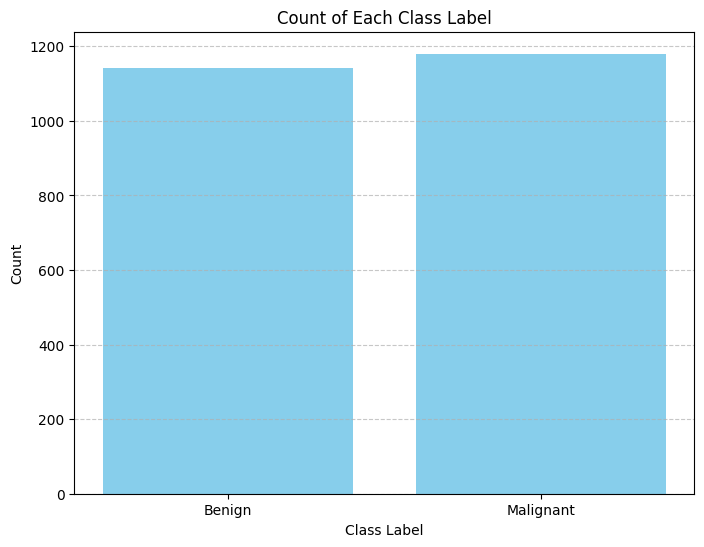

In [32]:
unique_labels, label_counts = np.unique(train_labels, return_counts=True)
class_labels = {0: 'Benign', 1: 'Malignant'}
# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.bar(unique_labels, label_counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Count of Each Class Label')
plt.xticks(list(class_labels.keys()), [class_labels[label] for label in unique_labels])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##Data Preprocessing

1. normalize_dataset(images, labels, batch_size):
  * Prepares a TensorFlow dataset by normalizing input images and batching them for model training.
2. normalize_volume(volume):
  * Normalizes a single volume of images for consistent data processing.

In [33]:
def normalize_volume(volume):
    volume = tf.cast(volume, tf.float32)
    mean_value = tf.reduce_mean(volume)
    std_value = tf.math.reduce_std(volume)
    return (volume - mean_value) / std_value

In [34]:
def normalize_dataset(images, labels, batch_size):
    image_dataset = tf.data.Dataset.from_tensor_slices(images)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)
    combined_dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
    shuffled_dataset = combined_dataset.shuffle(2500)
    normalized_dataset = shuffled_dataset.map(lambda image, label: (normalize_volume(image), label))
    batched_dataset = normalized_dataset.batch(batch_size)

    return batched_dataset

In [35]:
def create_datasets(train_imgs,train_labels,val_imgs,val_labels,batch_size):

  train_dataset=normalize_dataset(train_imgs,train_labels,batch_size=batch_size)
  val_dataset=normalize_dataset(val_imgs,val_labels,batch_size=batch_size)

  return train_dataset, val_dataset

# Model

In [36]:
def create_3d_convolutional_model(input_shape=(28, 28, 28, 1), num_classes=1, learning_rate=0.0001):
    # Define model architecture
    model = models.Sequential([
        layers.Conv3D(32, (3, 3, 3), activation='relu', input_shape=input_shape),
        layers.Conv3D(32, (3, 3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2, 2, 2)),
        layers.Conv3D(64, (3, 3, 3), activation='relu'),
        layers.Conv3D(64, (3, 3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2, 2, 2)),
        layers.Conv3D(32, (3, 3, 3), activation='relu'),
        layers.MaxPooling3D((2, 2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')
    ])

    # Configure optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.metrics.AUC()])

    return model

#Train

In [41]:
model_path = '/content/drive/MyDrive/Data/nodule/'

In [42]:
learning_rate=0.00001
epochs=20
batch_size=16

## Create datasets

In [43]:
train_dataset, val_dataset=create_datasets(train_imgs,train_labels,val_imgs,val_labels,batch_size)

In [44]:
# dataset_details(train_dataset)

In [45]:
# dataset_details(val_dataset)

## Create model and train

In [46]:
model = create_3d_convolutional_model(learning_rate=learning_rate)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 26, 26, 26, 32)    896       
                                                                 
 conv3d_1 (Conv3D)           (None, 24, 24, 24, 32)    27680     
                                                                 
 batch_normalization (Batch  (None, 24, 24, 24, 32)    128       
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 12, 12, 12, 32)    0         
 D)                                                              
                                                                 
 conv3d_2 (Conv3D)           (None, 10, 10, 10, 64)    55360     
                                                                 
 conv3d_3 (Conv3D)           (None, 8, 8, 8, 64)       1

In [47]:
callbacks = [
    ModelCheckpoint(filepath=model_path+'model_checkpoint.h5', save_best_only=True),
    # ModelCheckpoint(filepath='weights_checkpoint.h5', save_best_only=True, save_weights_only=True),
    # EarlyStopping(monitor='val_loss', patience=3),
    CSVLogger(filename=model_path+'training_metrics.csv')
]

In [48]:
log_dir = model_path+"logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Train the model
history = model.fit(train_dataset, epochs=epochs, batch_size=batch_size, validation_data=val_dataset,callbacks=[callbacks,tensorboard_callback])

In [ ]:
# %tensorboard --logdir logs/fit

## Visualization

Visualize results

In [56]:
best_checkpoint=tf.keras.models.load_model(model_path+'model_checkpoint.h5')

In [ ]:
plot_learning_curves(history)

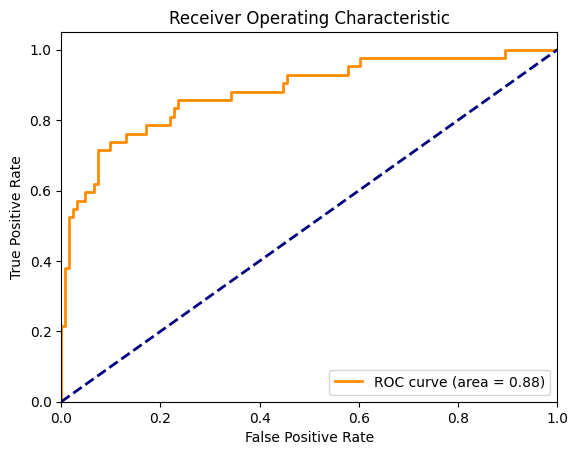

In [57]:
plot_roc_curve(best_checkpoint,val_dataset)

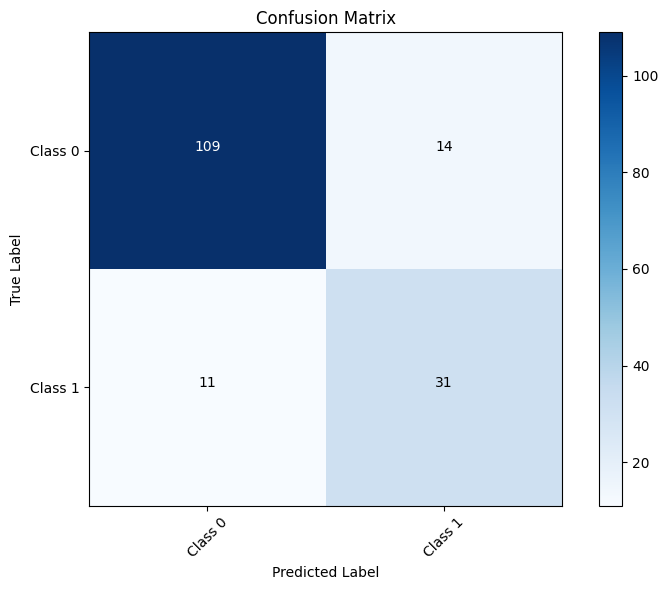

In [58]:
plot_confusion_matrix(best_checkpoint,val_dataset)

# Hyperparameter Tuning

**Incomplete**

In [ ]:
# !pip install scikeras

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from scikeras.wrappers import KerasClassifier
from sklearn.base import BaseEstimator

In [ ]:
class KerasModelWrapper(KerasClassifier, BaseEstimator):
    def __init__(self, build_fn=None, **kwargs):
        super().__init__(build_fn=build_fn, **kwargs)

    def fit(self, X, y, **kwargs):
        return super().fit(X, y, **kwargs)

In [ ]:
model_path = '/content/drive/MyDrive/Data/nodule/'

In [ ]:
def load_data_hyper(batch_size):
  train_imgs,train_labels,val_imgs,val_labels=load_nodulemnist()
  train_imgs,train_labels=load_additional_data(model_path+'rotated_augmented_images.npz',train_imgs,train_labels,c='m')
  train_imgs,train_labels=load_additional_data(model_path+'flipped_augmented_images.npz',train_imgs,train_labels,c='m')
  train_imgs,train_labels=load_additional_data(model_path+'noisy_images_m.npz',train_imgs,train_labels,c='m')
  train_imgs,train_labels=load_additional_data(model_path+'noisy_images_b.npz',train_imgs,train_labels,c='b')
  train_dataset, val_dataset=create_datasets(train_imgs,train_labels,val_imgs,val_labels,batch_size)
  return train_dataset, val_dataset

In [ ]:
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'batch_size': [8, 16, 32, 64],
}

In [ ]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score, needs_proba=True),
}

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /root/.medmnist/nodulemnist3d.npz
New images =  295
Random index =  167


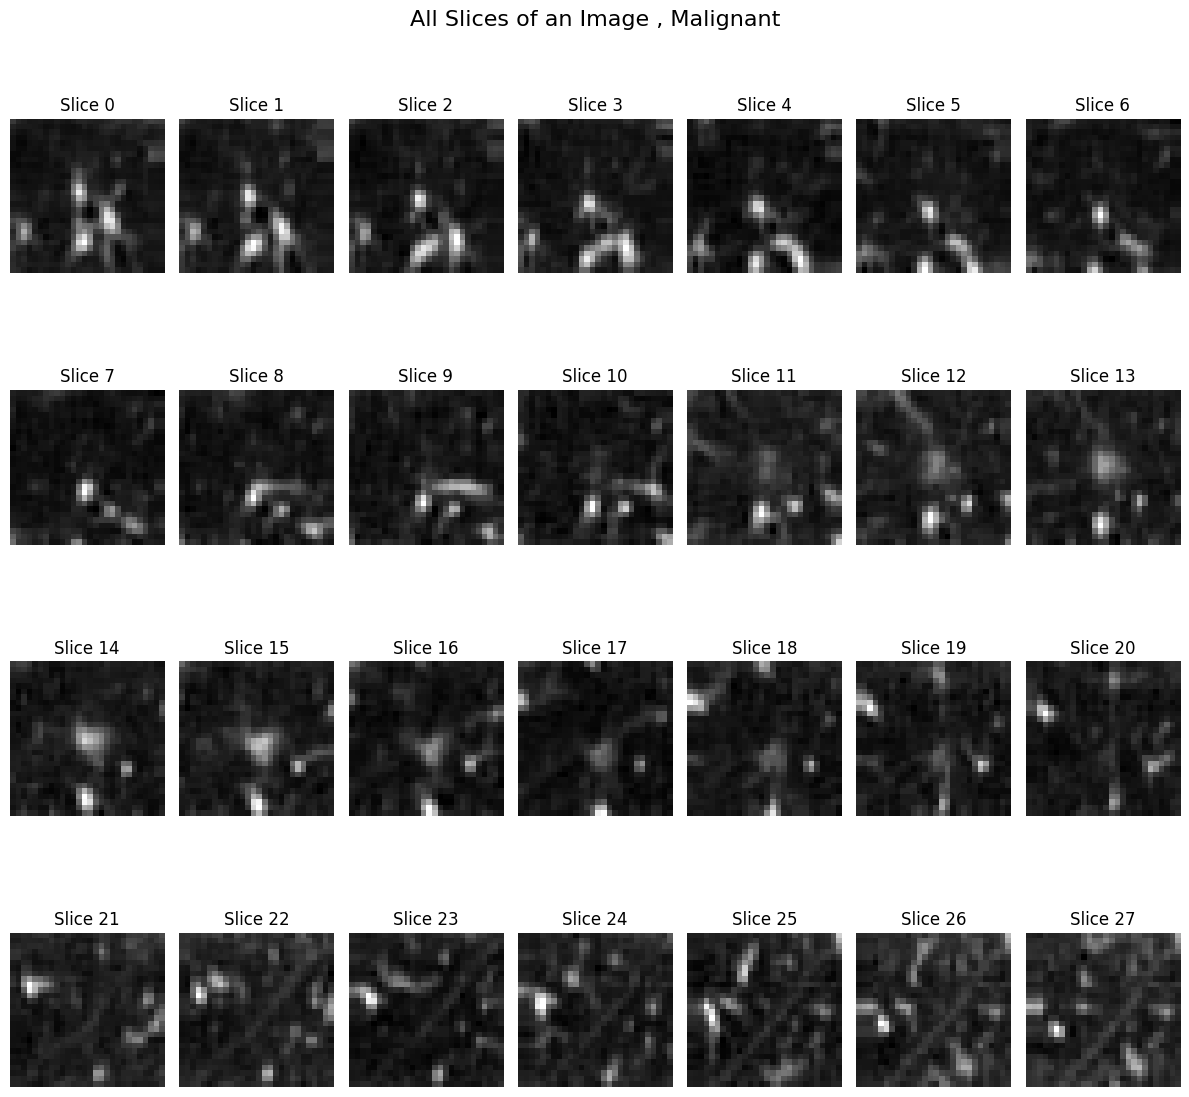

New images =  295
Random index =  137


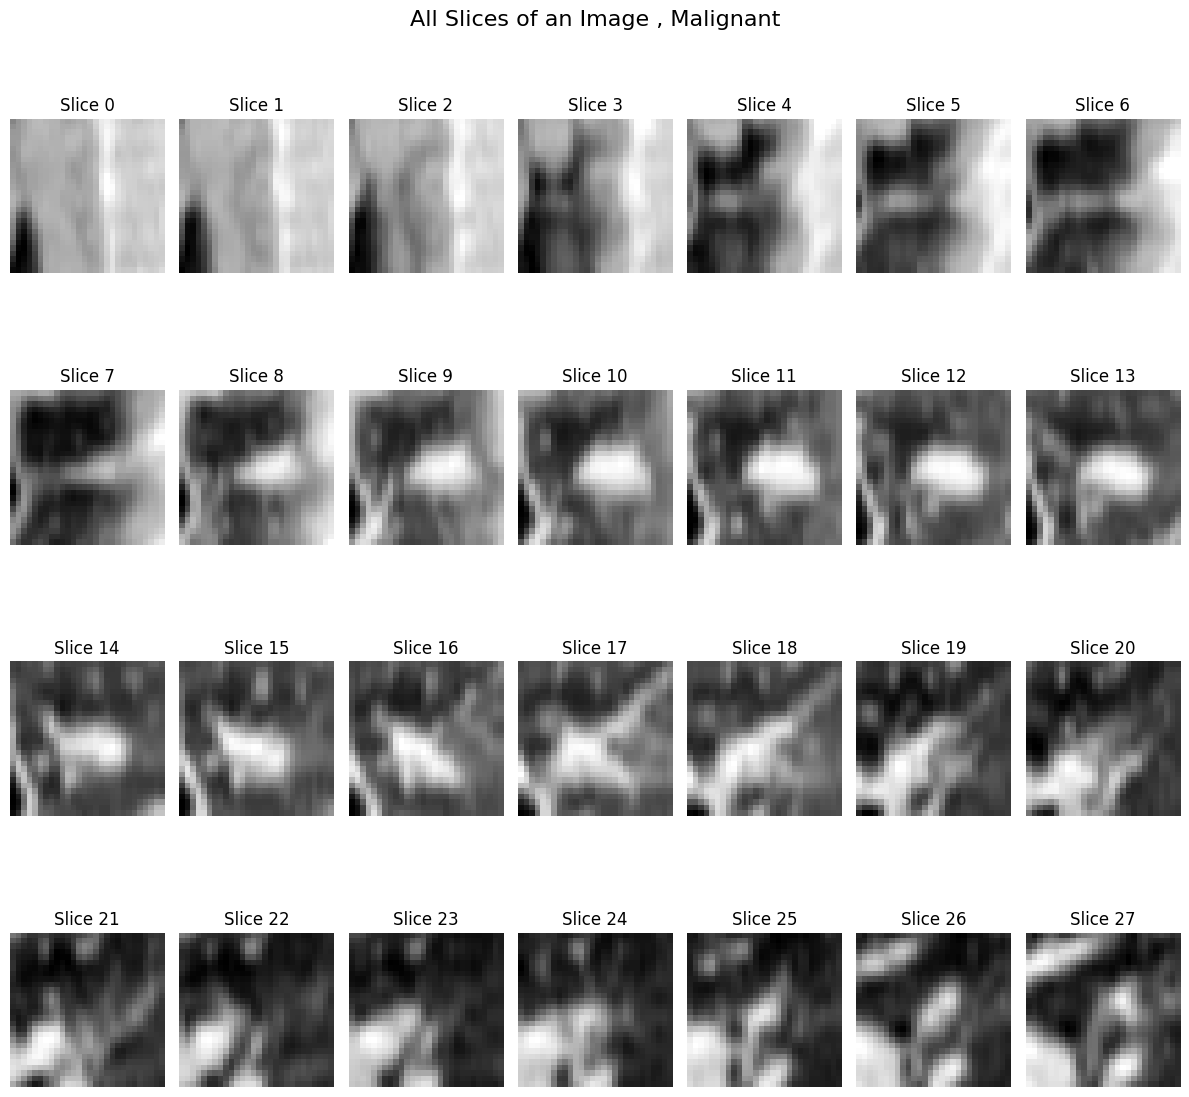

New images =  295
Random index =  221


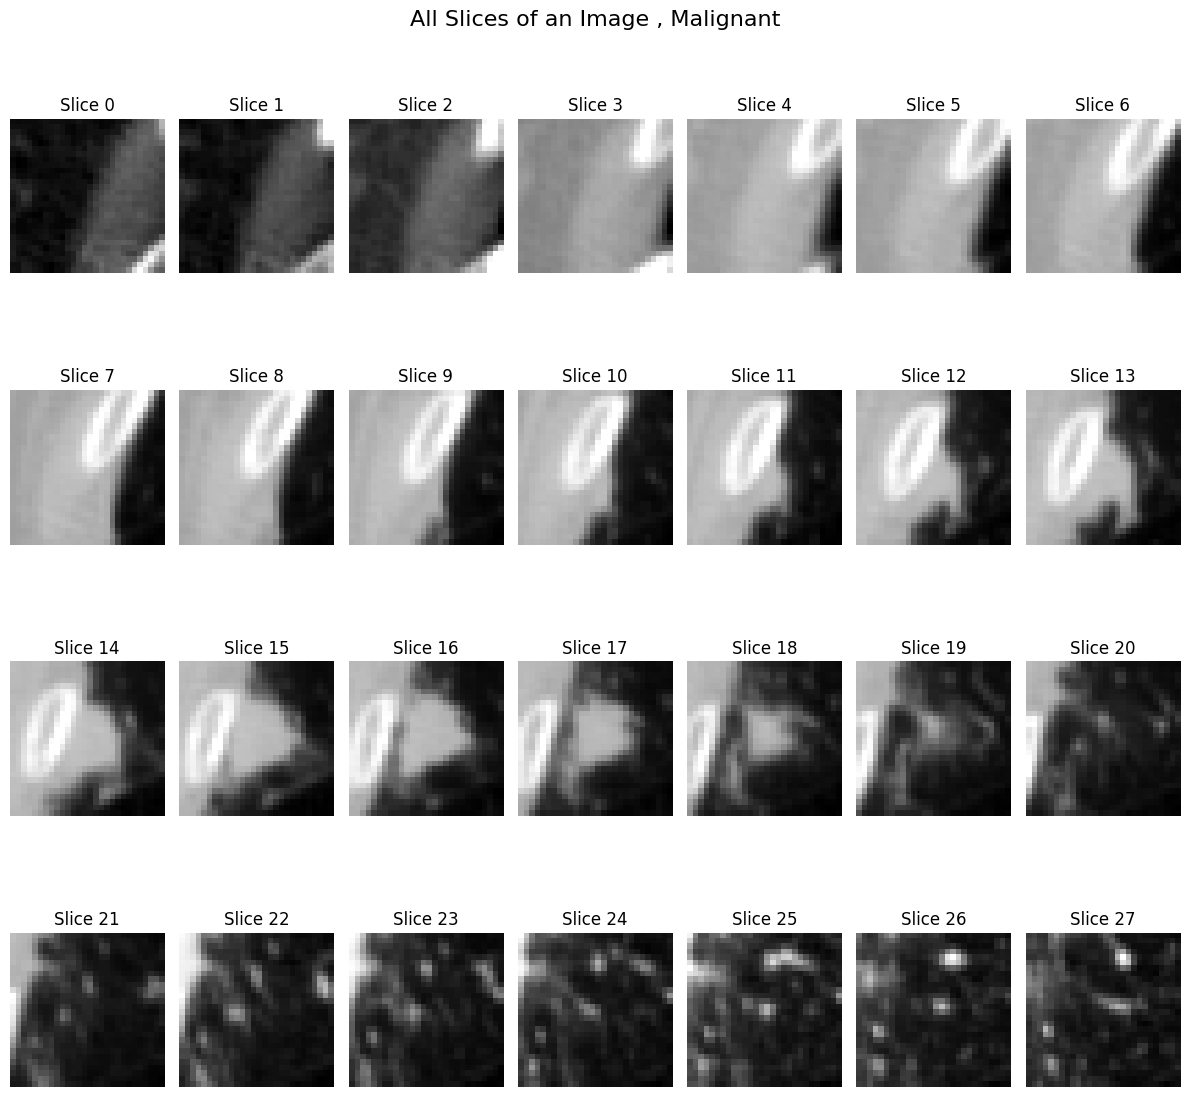

New images =  280
Random index =  122


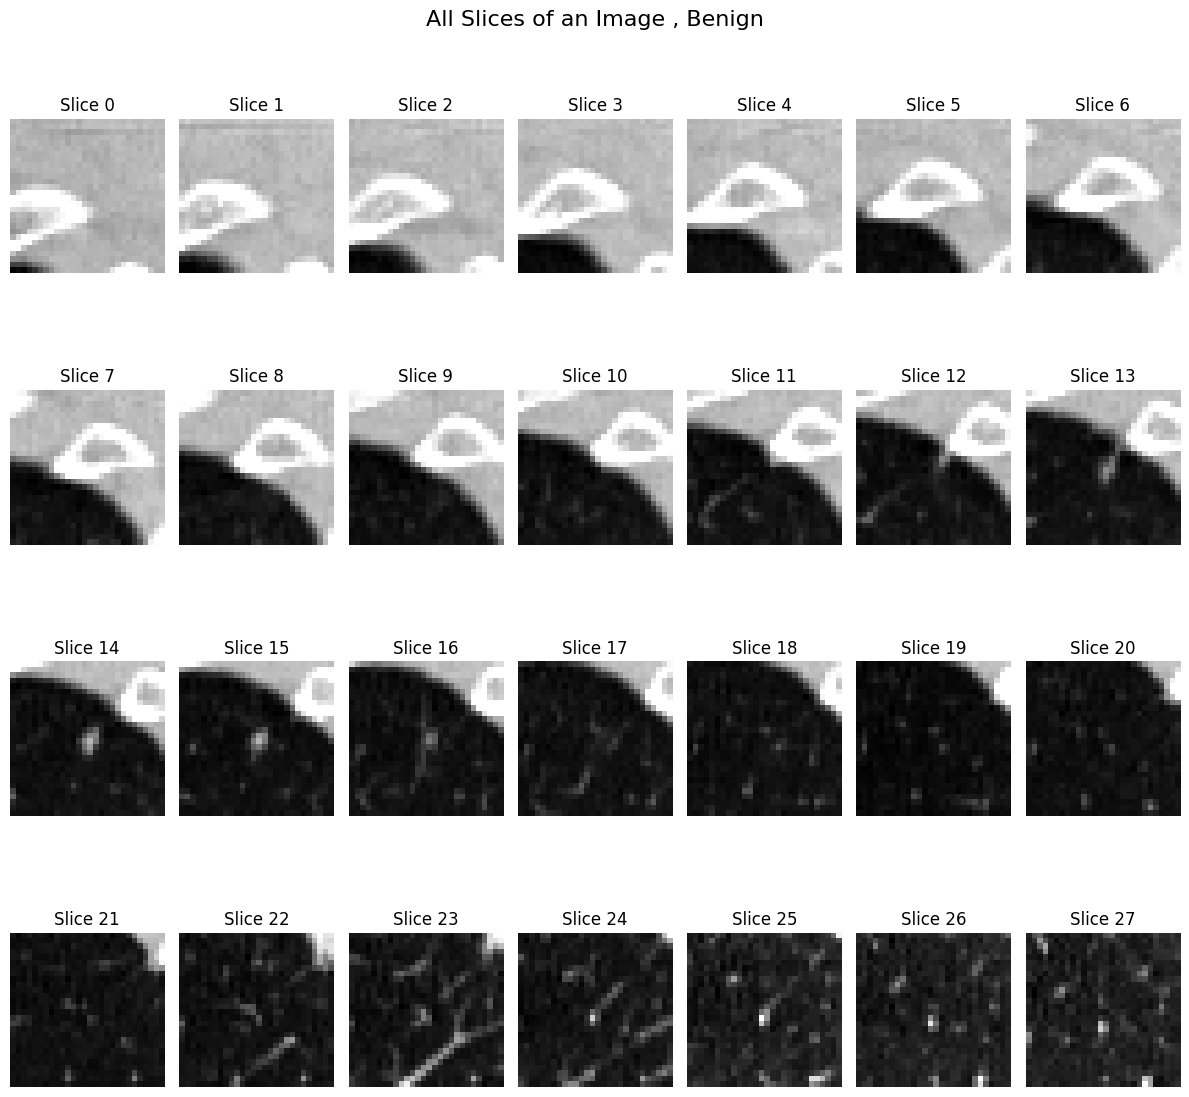

In [ ]:
train_dataset, val_dataset=load_data_hyper(4)
X_train,y_train=tf_2_numpy(train_dataset)

In [ ]:
estimator = KerasModelWrapper(build_fn=create_3d_convolutional_model, epochs=10, learning_rate=0.0001)

In [ ]:
# Perform grid search
grid_search = GridSearchCV(estimator, param_grid, cv=3, scoring=scoring, refit='accuracy', verbose=1)

In [ ]:
grid_result = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


ValueError: 
All the 48 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_1/conv3d_5_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_1/batch_normalization_4_1/batchnorm/add_1, sequential_1/conv3d_5_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_1_1/conv3d_11_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_1_1/batch_normalization_11_1/batchnorm/add_1, sequential_1_1/conv3d_11_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_2_1/conv3d_17_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_2_1/batch_normalization_18_1/batchnorm/add_1, sequential_2_1/conv3d_17_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_3_1/conv3d_23_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_3_1/batch_normalization_25_1/batchnorm/add_1, sequential_3_1/conv3d_23_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_4_1/conv3d_29_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_4_1/batch_normalization_32_1/batchnorm/add_1, sequential_4_1/conv3d_29_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_5_1/conv3d_35_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_5_1/batch_normalization_39_1/batchnorm/add_1, sequential_5_1/conv3d_35_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_6_1/conv3d_41_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_6_1/batch_normalization_46_1/batchnorm/add_1, sequential_6_1/conv3d_41_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_7_1/conv3d_47_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_7_1/batch_normalization_53_1/batchnorm/add_1, sequential_7_1/conv3d_47_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_8_1/conv3d_53_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_8_1/batch_normalization_60_1/batchnorm/add_1, sequential_8_1/conv3d_53_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_9_1/conv3d_59_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_9_1/batch_normalization_67_1/batchnorm/add_1, sequential_9_1/conv3d_59_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_10_1/conv3d_65_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_10_1/batch_normalization_74_1/batchnorm/add_1, sequential_10_1/conv3d_65_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_11_1/conv3d_71_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_11_1/batch_normalization_81_1/batchnorm/add_1, sequential_11_1/conv3d_71_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_12_1/conv3d_77_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_12_1/batch_normalization_88_1/batchnorm/add_1, sequential_12_1/conv3d_77_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_13_1/conv3d_83_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_13_1/batch_normalization_95_1/batchnorm/add_1, sequential_13_1/conv3d_83_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_14_1/conv3d_89_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_14_1/batch_normalization_102_1/batchnorm/add_1, sequential_14_1/conv3d_89_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_15_1/conv3d_95_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_15_1/batch_normalization_109_1/batchnorm/add_1, sequential_15_1/conv3d_95_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_16_1/conv3d_101_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_16_1/batch_normalization_116_1/batchnorm/add_1, sequential_16_1/conv3d_101_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_17_1/conv3d_107_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_17_1/batch_normalization_123_1/batchnorm/add_1, sequential_17_1/conv3d_107_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_18_1/conv3d_113_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_18_1/batch_normalization_130_1/batchnorm/add_1, sequential_18_1/conv3d_113_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_19_1/conv3d_119_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_19_1/batch_normalization_137_1/batchnorm/add_1, sequential_19_1/conv3d_119_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_20_1/conv3d_125_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_20_1/batch_normalization_144_1/batchnorm/add_1, sequential_20_1/conv3d_125_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_21_1/conv3d_131_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_21_1/batch_normalization_151_1/batchnorm/add_1, sequential_21_1/conv3d_131_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_22_1/conv3d_137_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_22_1/batch_normalization_158_1/batchnorm/add_1, sequential_22_1/conv3d_137_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_23_1/conv3d_143_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_23_1/batch_normalization_165_1/batchnorm/add_1, sequential_23_1/conv3d_143_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_24_1/conv3d_149_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_24_1/batch_normalization_172_1/batchnorm/add_1, sequential_24_1/conv3d_149_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_25_1/conv3d_155_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_25_1/batch_normalization_179_1/batchnorm/add_1, sequential_25_1/conv3d_155_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_26_1/conv3d_161_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_26_1/batch_normalization_186_1/batchnorm/add_1, sequential_26_1/conv3d_161_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_27_1/conv3d_167_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_27_1/batch_normalization_193_1/batchnorm/add_1, sequential_27_1/conv3d_167_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_28_1/conv3d_173_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_28_1/batch_normalization_200_1/batchnorm/add_1, sequential_28_1/conv3d_173_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_29_1/conv3d_179_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_29_1/batch_normalization_207_1/batchnorm/add_1, sequential_29_1/conv3d_179_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_30_1/conv3d_185_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_30_1/batch_normalization_214_1/batchnorm/add_1, sequential_30_1/conv3d_185_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_31_1/conv3d_191_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_31_1/batch_normalization_221_1/batchnorm/add_1, sequential_31_1/conv3d_191_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_32_1/conv3d_197_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_32_1/batch_normalization_228_1/batchnorm/add_1, sequential_32_1/conv3d_197_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_33_1/conv3d_203_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_33_1/batch_normalization_235_1/batchnorm/add_1, sequential_33_1/conv3d_203_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_34_1/conv3d_209_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_34_1/batch_normalization_242_1/batchnorm/add_1, sequential_34_1/conv3d_209_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_35_1/conv3d_215_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_35_1/batch_normalization_249_1/batchnorm/add_1, sequential_35_1/conv3d_215_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_36_1/conv3d_221_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_36_1/batch_normalization_256_1/batchnorm/add_1, sequential_36_1/conv3d_221_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_37_1/conv3d_227_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_37_1/batch_normalization_263_1/batchnorm/add_1, sequential_37_1/conv3d_227_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_38_1/conv3d_233_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_38_1/batch_normalization_270_1/batchnorm/add_1, sequential_38_1/conv3d_233_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_39_1/conv3d_239_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_39_1/batch_normalization_277_1/batchnorm/add_1, sequential_39_1/conv3d_239_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_40_1/conv3d_245_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_40_1/batch_normalization_284_1/batchnorm/add_1, sequential_40_1/conv3d_245_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_41_1/conv3d_251_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_41_1/batch_normalization_291_1/batchnorm/add_1, sequential_41_1/conv3d_251_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_42_1/conv3d_257_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_42_1/batch_normalization_298_1/batchnorm/add_1, sequential_42_1/conv3d_257_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_43_1/conv3d_263_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_43_1/batch_normalization_305_1/batchnorm/add_1, sequential_43_1/conv3d_263_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_44_1/conv3d_269_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_44_1/batch_normalization_312_1/batchnorm/add_1, sequential_44_1/conv3d_269_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_45_1/conv3d_275_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_45_1/batch_normalization_319_1/batchnorm/add_1, sequential_45_1/conv3d_275_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_46_1/conv3d_281_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_46_1/batch_normalization_326_1/batchnorm/add_1, sequential_46_1/conv3d_281_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-52-f7ac798ec2e7>", line 6, in fit
    return super().fit(X, y, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 535, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling Conv3D.call().

[1mNegative dimension size caused by subtracting 3 from 2 for '{{node sequential_47_1/conv3d_287_1/convolution}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](sequential_47_1/batch_normalization_333_1/batchnorm/add_1, sequential_47_1/conv3d_287_1/convolution/ReadVariableOp)' with input shapes: [?,2,2,2,128], [3,3,3,128,128].[0m

Arguments received by Conv3D.call():
  • inputs=tf.Tensor(shape=(None, 2, 2, 2, 128), dtype=float32)


In [ ]:
# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
# # Print the best parameters and best scores
# print("Best parameters found: ", grid_search.best_params_)
# print("Best accuracy: ", grid_search.best_score_)
# print("Best AUC: ", grid_search.cv_results_['mean_test_auc'][grid_search.best_index_])
# print("Best negative log loss: ", grid_search.cv_results_['mean_test_neg_loss'][grid_search.best_index_])